In [15]:
!pip install mplcyberpunk

In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from warnings import filterwarnings
#for dirname, _, filenames in os.walk('/kaggle/input'):
  #  for filename in filenames:
    #    print(os.path.join(dirname, filename))

In [17]:
# Label list
X_train = []
y_train = []
labels = ['glioma', 'notumor', 'meningioma', 'pituitary']
image_size = 224  # For VGG16/19 compatibility

# Initialize lists
X_data = []
y_data = []

# Load Training data
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
for label in labels:
    folderPath = os.path.join(train_dir, label)
    for file in tqdm(os.listdir(folderPath), desc=f"Loading {label} (Training)"):
        img_path = os.path.join(folderPath, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_data.append(img)
            y_data.append(label)

# Load Testing data
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"
for label in labels:
    folderPath = os.path.join(test_dir, label)
    for file in tqdm(os.listdir(folderPath), desc=f"Loading {label} (Testing)"):
        img_path = os.path.join(folderPath, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_data.append(img)
            y_data.append(label)

# Convert to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

print("Shape of X_data:", X_data.shape)
print("Sample labels:", np.unique(y_data, return_counts=True))


Loading pituitary (Testing): 100%|██████████| 300/300 [00:00<00:00, 414.41it/s]


Shape of X_data: (7023, 224, 224, 3)
Sample labels: (array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10'), array([1621, 1645, 2000, 1757]))


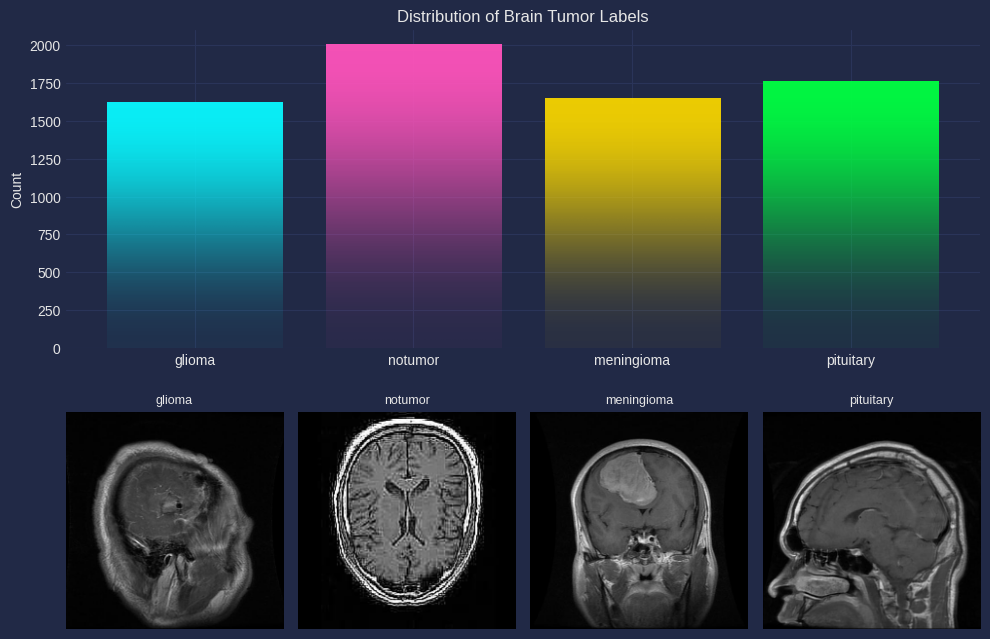

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import mplcyberpunk

# Step 1: Convert y_data (str labels) to numpy array if not already
y_data = np.array(y_data)

# Step 2: Count the number of samples per label
label_counts = {label: np.sum(y_data == label) for label in labels}

# Step 3: Plot bar plot and sample images together
plt.figure(figsize=(10, 7))

# --- Bar plot
colors = ["C0", "C1", "C2", "C3"]
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.ylabel('Count')
plt.title('Distribution of Brain Tumor Labels')

# --- Sample images
shown_labels = set()
k = 0
for idx, label in enumerate(y_data):
    if label not in shown_labels:
        plt.subplot(2, 4, k + 5)
        plt.imshow(X_data[idx].astype(np.uint8))
        plt.title(label, fontsize=9)
        plt.axis('off')
        shown_labels.add(label)
        k += 1
    if len(shown_labels) == len(labels):
        break

plt.tight_layout()
plt.show()


In [19]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

X_data = np.array(X_data)
y_data = np.array(y_data)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.1, random_state=101, stratify=y_data
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (6320, 224, 224, 3) (6320,)
Test shape: (703, 224, 224, 3) (703,)


In [21]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.

datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

In [22]:
# Step 1: Fix your labels list (already correct)
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Step 2: If y_train is one-hot encoded, get class index using argmax
y_train_encoded = [np.argmax(label) for label in y_train]
y_test_encoded = [np.argmax(label) for label in y_test]

# Step 3: Optional — convert back to class label if needed
y_train_labels = [labels[i] for i in y_train_encoded]
y_test_labels = [labels[i] for i in y_test_encoded]


In [23]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))


# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1752055595.985372      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752055595.986017      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [25]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [26]:
# Make sure X_train is a NumPy array
X_train = np.array(X_train)

# Encode y_train if it's in string labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)         # Convert string → int
y_train_encoded = to_categorical(y_train_encoded)              # Convert int → one-hot

# Now train the model
history = model.fit(
    X_train,
    y_train_encoded,
    validation_split=0.1,
    epochs=5,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)


Epoch 1/5


I0000 00:00:1752055652.770140     113 service.cc:148] XLA service 0x799c180ab590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752055652.770937     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752055652.770972     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752055657.590889     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752055667.639612     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752055667.783434     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752055668.223738     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8392 - loss: 0.4405

E0000 00:00:1752055721.313558     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752055721.454756     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752055721.884366     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752055722.025567     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8396 - loss: 0.4396
Epoch 1: val_accuracy improved from -inf to 0.92880, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 153s 364ms/step - accuracy: 0.8399 - loss: 0.4387 - val_accuracy: 0.9288 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9635 - loss: 0.1068
Epoch 2: val_accuracy improved from 0.92880 to 0.94146, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9635 - loss: 0.1069 - val_accuracy: 0.9415 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9747 - loss: 0.0867
Epoch 3: val_accuracy improved from 0.94146 to 0.96994, saving model to efficientnetB0.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.9747 - loss: 0.0867 - val_accuracy: 0.9699 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0

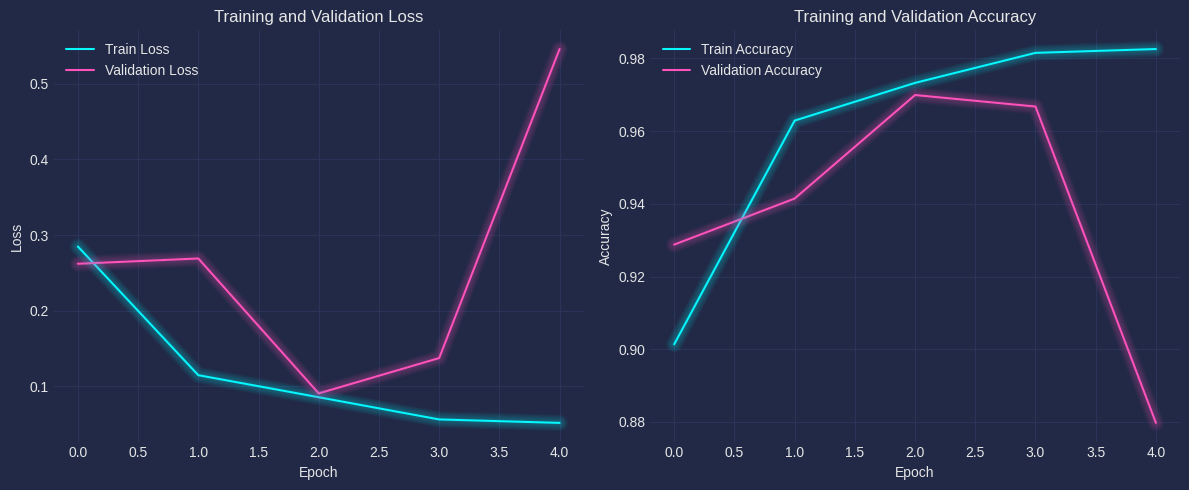

In [27]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step


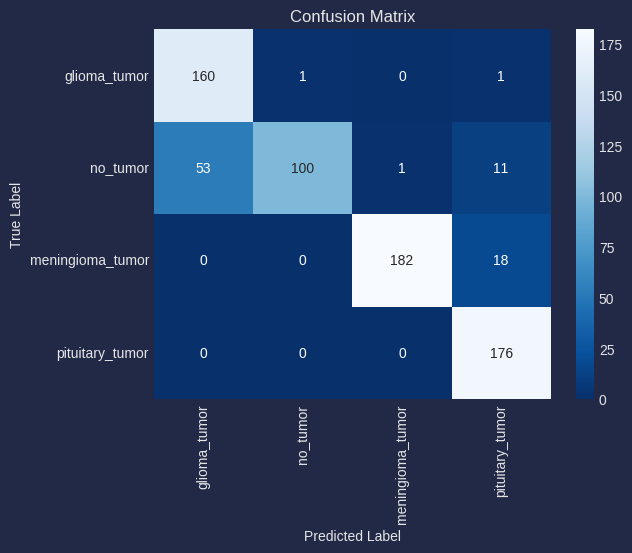

In [28]:
y_true_test = label_encoder.transform(y_test) 

y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Calculate class-wise accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print class-wise accuracy
for i, acc in enumerate(class_accuracies):
    print(f"Accuracy for class '{labels[i]}': {acc:.2%}")

Accuracy for class 'glioma_tumor': 98.77%
Accuracy for class 'no_tumor': 60.61%
Accuracy for class 'meningioma_tumor': 91.00%
Accuracy for class 'pituitary_tumor': 100.00%


In [30]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.99      0.85       162
           1       0.99      0.61      0.75       165
           2       0.99      0.91      0.95       200
           3       0.85      1.00      0.92       176

    accuracy                           0.88       703
   macro avg       0.90      0.88      0.87       703
weighted avg       0.90      0.88      0.87       703



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted label: meningioma
Actual label: meningioma
Confidence: 98.15%


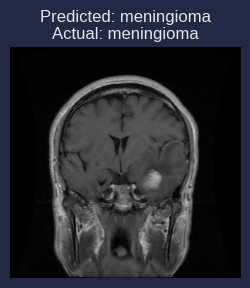

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# - model (your trained ResNet101 model)
# - X_test (numpy array of shape: [num_samples, 224, 224, 3])
# - y_test (either one-hot encoded OR string labels)
# - label_encoder (used during training)
# - labels (optional: your custom label list)

# Step 1: Select a random test image
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]

# Step 2: Predict the class
predictions = model.predict(random_img.reshape(1, 224, 224, 3))  # Add batch dim
predicted_class_index = np.argmax(predictions)
predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]
confidence = predictions[0][predicted_class_index]

# Step 3: Get the actual label
# If y_test is one-hot encoded:
if len(y_test[random_index].shape) > 0:
    actual_class_index = np.argmax(y_test[random_index])
else:
    actual_class_index = y_test[random_index]  # Already class index or label

# Decode to label
try:
    actual_label = label_encoder.inverse_transform([actual_class_index])[0]
except:
    actual_label = actual_class_index  # Already a label string

# Step 4: Display the prediction results
print(f"\033[94mPredicted label: {predicted_label}\033[0m")
print(f"\033[92mActual label: {actual_label}\033[0m")
print(f"\033[93mConfidence: {confidence*100:.2f}%\033[0m")

# Step 5: Show the image
plt.figure(figsize=(3, 3))
plt.imshow(random_img.astype(np.uint8))
plt.axis('off')
plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
plt.show()

In [32]:
model.save("brain_tumor_efficient.h5")